In [1]:
import anndata as ad
import numpy as np
import pandas as pd

In [2]:
mean_df  = pd.read_csv("/large_storage/ctc/userspace/aadduri/preprint/replogle_filtered_globalsimplesum/rpe1/eval_final.ckpt/rpe1_results.csv")
sets_df = pd.read_csv("/large_storage/ctc/userspace/aadduri/preprint/replogle_llama_21712320_filtered_copy/rpe1/eval_step=56000.ckpt/rpe1_results.csv")
sets_df['discrimination_score'].mean()

0.2917127341311134

In [ ]:
adata_pred_mean = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_filtered_globalsimplesum/rpe1/eval_final.ckpt/adata_pred.h5ad')
adata_real_mean = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_filtered_globalsimplesum/rpe1/eval_final.ckpt/adata_real.h5ad')

adata_pred = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_llama_21712320_filtered/rpe1/eval_step=56000.ckpt/adata_pred.h5ad')
adata_real = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_llama_21712320_filtered/rpe1/eval_step=56000.ckpt/adata_real.h5ad')

In [8]:
mean_df['discrimination_score_rev'] = compute_perturbation_ranking_score_rev(adata_pred_mean, adata_real_mean)
sets_df['discrimination_score_rev'] = compute_perturbation_ranking_score_rev(adata_pred, adata_real)

/tmp/ipykernel_3177637/3577440614.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3177637/3577440614.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3177637/3577440614.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3177637/3577440614.py:4: 

In [7]:
def compute_mean_perturbation_effect(adata, pert_col="gene", ctrl_pert="non-targeting"):
    adata_df = adata.to_df()
    adata_df["pert"] = adata.obs[pert_col].values
    mean_df = adata_df.groupby("pert").mean()
    mean_pert_effect = np.abs(mean_df - mean_df.loc[ctrl_pert])
    return mean_pert_effect

def compute_perturbation_id_score(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting"):
    # Compute true and predicted mean effects
    mean_real = compute_mean_perturbation_effect(adata_real, pert_col, ctrl_pert)
    mean_pred = compute_mean_perturbation_effect(adata_pred, pert_col, ctrl_pert)
    perts = mean_real.index.values

    pred_perts = []
    for pert in perts:
        real_eff = mean_real.loc[pert].values
        pred_effs = mean_pred.values
        # Euclidean distances to all predicted effects
        distances = np.linalg.norm(pred_effs - real_eff, axis=1)
        # pick the predicted perturbation with smallest distance
        pred_perts.append(perts[np.argmin(distances)])

    # accuracy
    return np.mean(np.array(pred_perts) == perts)

def compute_perturbation_ranking_score(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting"):
    mean_real = compute_mean_perturbation_effect(adata_real, pert_col, ctrl_pert)
    mean_pred = compute_mean_perturbation_effect(adata_pred, pert_col, ctrl_pert)
    perts = mean_real.index.values
    n = len(perts)

    ranks = []
    for i, pert in enumerate(perts):
        real_eff = mean_real.loc[pert].values
        pred_effs = mean_pred.values
        # distances
        distances = np.linalg.norm(pred_effs - real_eff, axis=1)
        # sort ascending → lowest distance = best match
        sorted_idx = np.argsort(distances)
        # find rank of the true perturbation
        rank = np.where(sorted_idx == i)[0][0]
        ranks.append(rank)

    # normalized mean rank
    return np.mean(ranks) / n

def compute_perturbation_ranking_score_rev(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting"):
    mean_real = compute_mean_perturbation_effect(adata_real, pert_col, ctrl_pert)
    mean_pred = compute_mean_perturbation_effect(adata_pred, pert_col, ctrl_pert)
    perts = mean_pred.index.values
    n = len(perts)

    ranks = []
    for i, pert in enumerate(perts):
        if pert == ctrl_pert:
            continue
        pred_eff = mean_pred.loc[pert].values
        real_effs = mean_real.values
        distances = np.linalg.norm(real_effs - pred_eff, axis=1)
        sorted_idx = np.argsort(distances)
        # true index in real_effs corresponds to pert’s position in mean_real.index
        true_idx = np.where(mean_real.index.values == pert)[0][0]
        rank = np.where(sorted_idx == true_idx)[0][0]
        ranks.append(rank)

    return np.array(ranks) / n

# compute_perturbation_ranking_score(adata_pred, adata_real), compute_perturbation_ranking_score(adata_pred_mean, adata_real_mean)

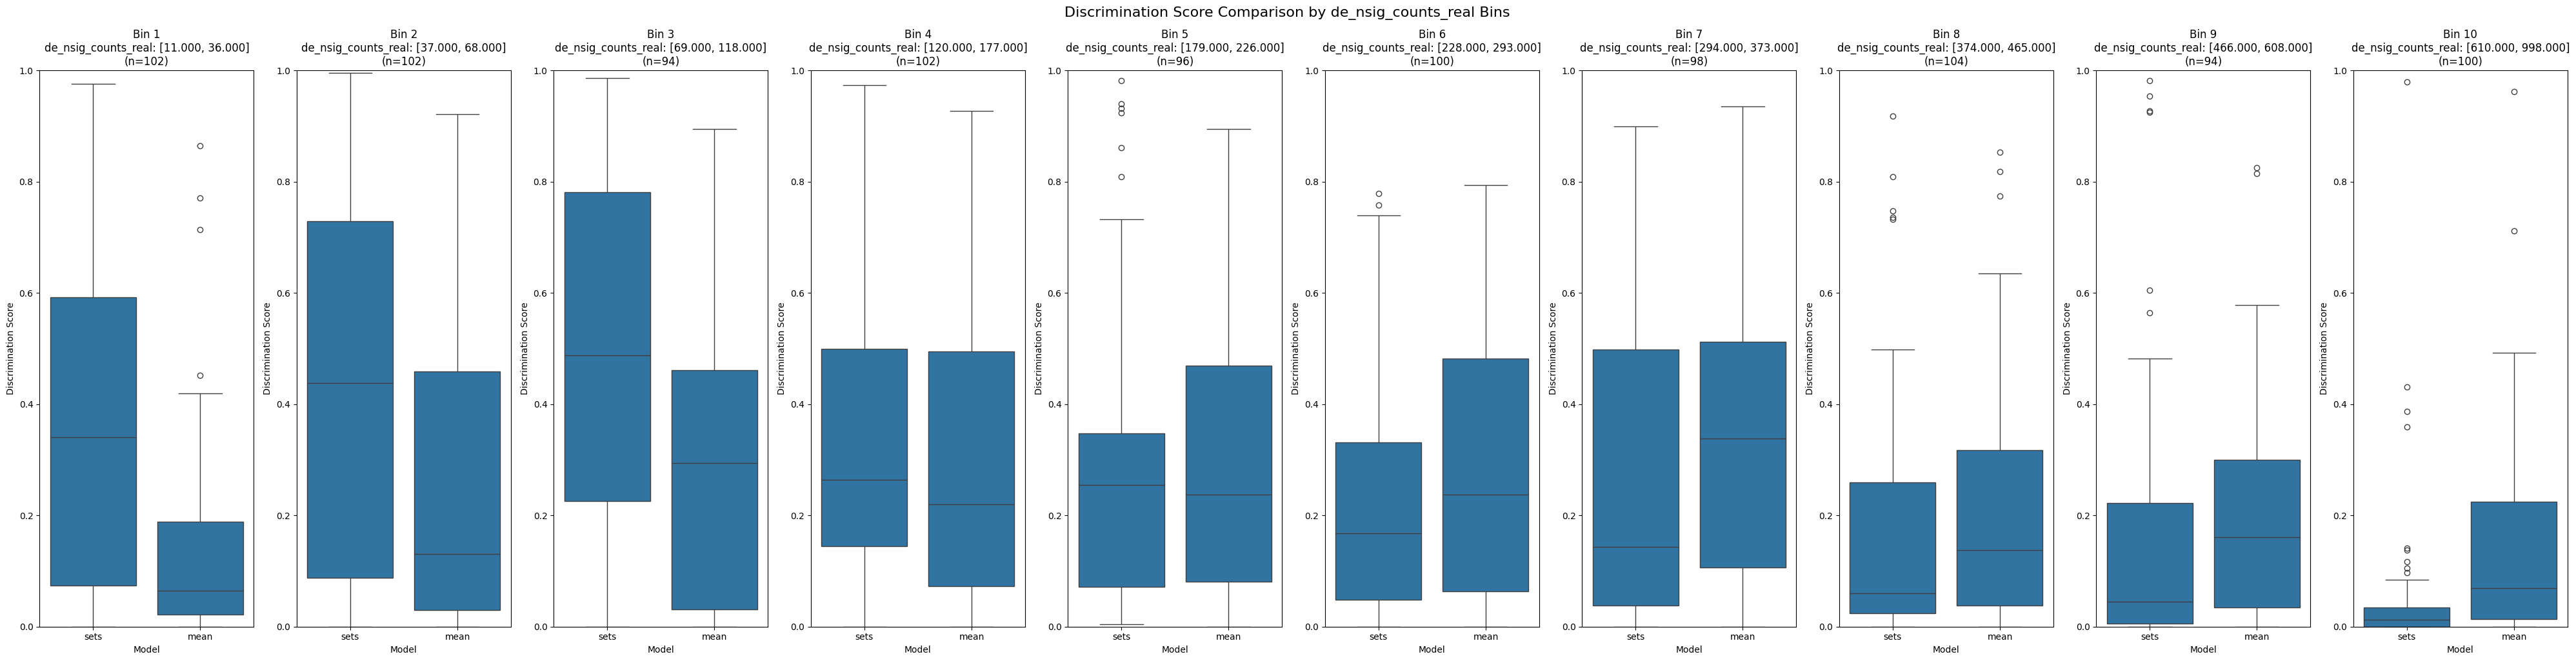


Summary Statistics by Effect Size Bin:

Bin 1:
Effect size range: [11.000, 36.000]
       count      mean       std    median
model                                     
mean      51  0.145557  0.201134  0.064516
sets      51  0.380811  0.311623  0.340726

Bin 2:
Effect size range: [37.000, 68.000]
       count      mean       std    median
model                                     
mean      51  0.262334  0.274944  0.131048
sets      51  0.440504  0.332549  0.437500

Bin 3:
Effect size range: [69.000, 118.000]
       count      mean       std    median
model                                     
mean      47  0.286891  0.259129  0.294355
sets      47  0.487646  0.319417  0.487903

Bin 4:
Effect size range: [120.000, 177.000]
       count      mean       std    median
model                                     
mean      51  0.307242  0.279147  0.219758
sets      51  0.358436  0.275283  0.264113

Bin 5:
Effect size range: [179.000, 226.000]
       count      mean       std    median
mode

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming sets_df and mean_df are available
# You may need to adjust the effect_size_column based on your data
effect_size_column = 'de_nsig_counts_real'  # Change this to your preferred effect size column

# Combine dataframes with model labels
sets_df_labeled = sets_df.copy()
sets_df_labeled['model'] = 'sets'

mean_df_labeled = mean_df.copy()
mean_df_labeled['model'] = 'mean'

# Combine both dataframes
combined_df = pd.concat([sets_df_labeled, mean_df_labeled], ignore_index=True)

# Remove any rows with NaN values in the effect size or discrimination score columns
combined_df = combined_df.dropna(subset=[effect_size_column, 'discrimination_score'])

# Create 10 effect size bins using quantiles
combined_df['effect_size_bin'] = pd.qcut(
    combined_df[effect_size_column], 
    q=10, 
    labels=[f'Bin {i+1}' for i in range(10)],
    duplicates='drop'  # Handle cases where there are duplicate bin edges
)

# Set up the plot
fig, axes = plt.subplots(1, 10, figsize=(40, 10))
axes = axes.flatten()

# Create box plots for each bin
for i, bin_label in enumerate(combined_df['effect_size_bin'].cat.categories):
    bin_data = combined_df[combined_df['effect_size_bin'] == bin_label]
    
    # Create box plot
    sns.boxplot(
        data=bin_data, 
        x='model', 
        y='discrimination_score', 
        ax=axes[i]
    )
    
    # Customize the subplot
    axes[i].set_title(f'{bin_label}\n(n={len(bin_data)})')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel('Discrimination Score')
    axes[i].set_ylim((0, 1.0))
    
    # Add effect size range to title
    bin_min = bin_data[effect_size_column].min()
    bin_max = bin_data[effect_size_column].max()
    axes[i].set_title(f'{bin_label}\n{effect_size_column}: [{bin_min:.3f}, {bin_max:.3f}]\n(n={len(bin_data)})')

# Adjust layout
plt.tight_layout()
plt.suptitle(f'Discrimination Score Comparison by {effect_size_column} Bins', 
             fontsize=16, y=1.02)

# Show the plot
plt.show()

# Optional: Print summary statistics for each bin
print("\nSummary Statistics by Effect Size Bin:")
print("="*60)

for bin_label in combined_df['effect_size_bin'].cat.categories:
    bin_data = combined_df[combined_df['effect_size_bin'] == bin_label]
    print(f"\n{bin_label}:")
    print(f"Effect size range: [{bin_data[effect_size_column].min():.3f}, {bin_data[effect_size_column].max():.3f}]")
    
    summary = bin_data.groupby('model')['discrimination_score'].agg(['count', 'mean', 'std', 'median'])
    print(summary)

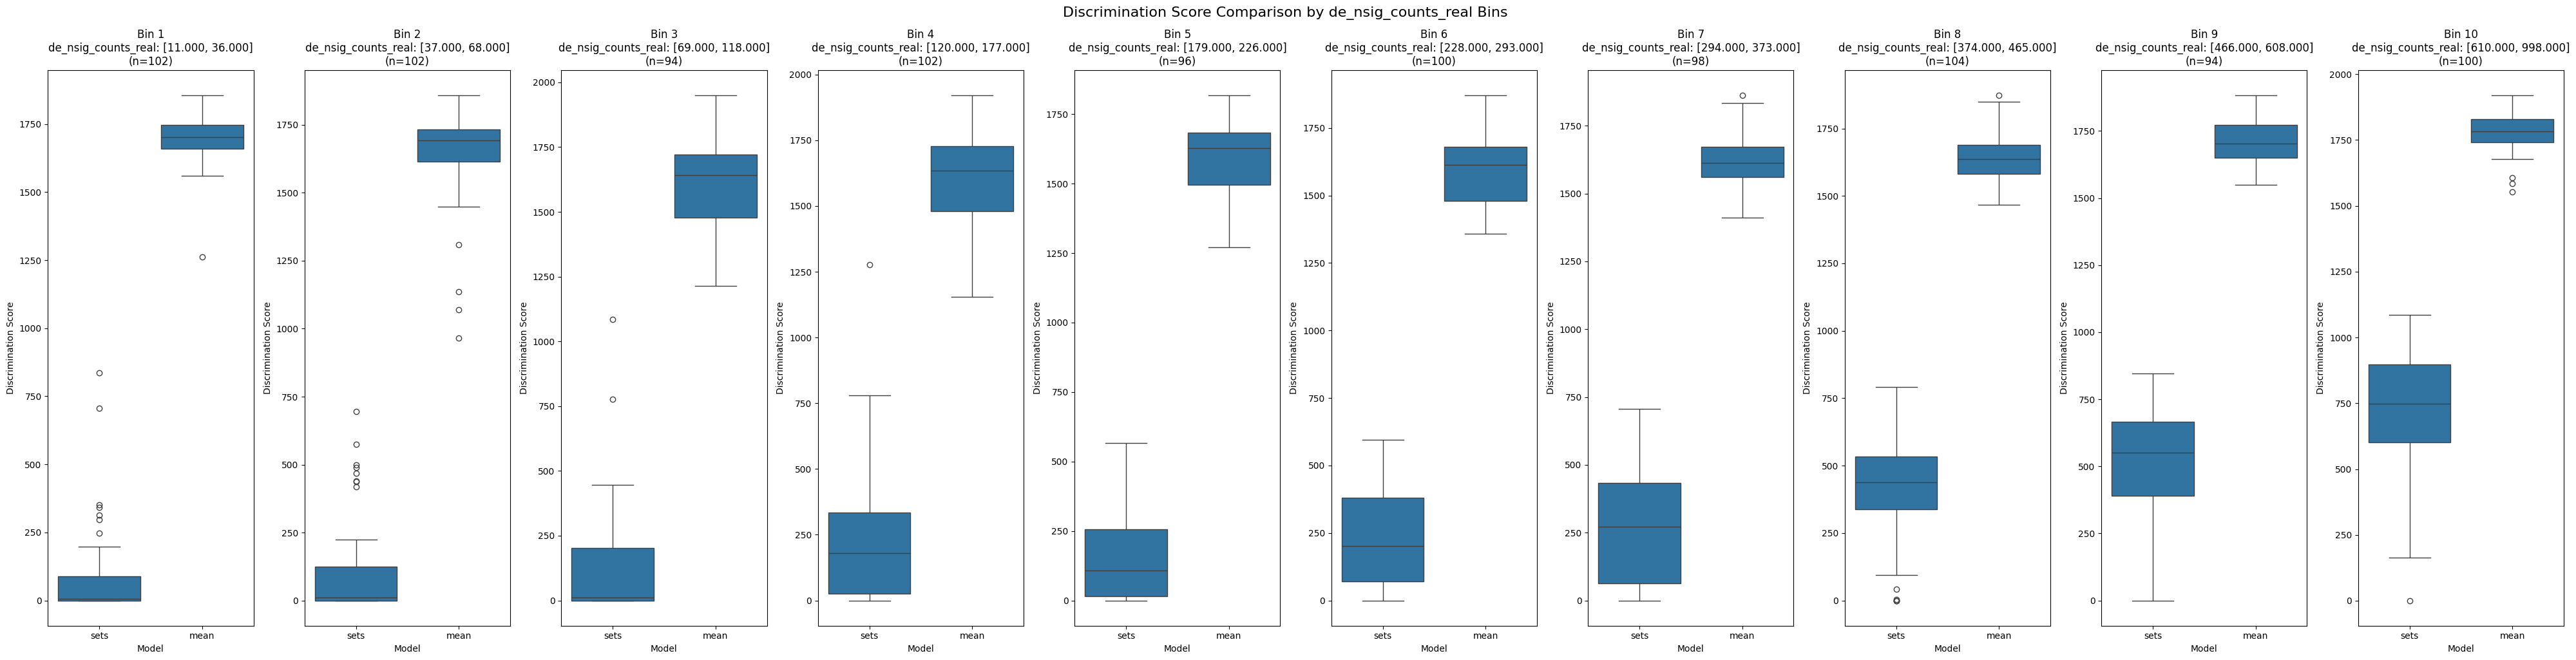


Summary Statistics by Effect Size Bin:

Bin 1:
Effect size range: [11.000, 36.000]
       count      mean       std    median
model                                     
mean      51  0.145557  0.201134  0.064516
sets      51  0.380811  0.311623  0.340726

Bin 2:
Effect size range: [37.000, 68.000]
       count      mean       std    median
model                                     
mean      51  0.262334  0.274944  0.131048
sets      51  0.440504  0.332549  0.437500

Bin 3:
Effect size range: [69.000, 118.000]
       count      mean       std    median
model                                     
mean      47  0.286891  0.259129  0.294355
sets      47  0.487646  0.319417  0.487903

Bin 4:
Effect size range: [120.000, 177.000]
       count      mean       std    median
model                                     
mean      51  0.307242  0.279147  0.219758
sets      51  0.358436  0.275283  0.264113

Bin 5:
Effect size range: [179.000, 226.000]
       count      mean       std    median
mode

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming sets_df and mean_df are available
# You may need to adjust the effect_size_column based on your data
effect_size_column = 'de_nsig_counts_real'  # Change this to your preferred effect size column

# Combine dataframes with model labels
sets_df_labeled = sets_df.copy()
sets_df_labeled['model'] = 'sets'

mean_df_labeled = mean_df.copy()
mean_df_labeled['model'] = 'mean'

# Combine both dataframes
combined_df = pd.concat([sets_df_labeled, mean_df_labeled], ignore_index=True)

# Remove any rows with NaN values in the effect size or discrimination score columns
combined_df = combined_df.dropna(subset=[effect_size_column, 'de_nsig_counts_pred'])

# Create 10 effect size bins using quantiles
combined_df['effect_size_bin'] = pd.qcut(
    combined_df[effect_size_column], 
    q=10, 
    labels=[f'Bin {i+1}' for i in range(10)],
    duplicates='drop'  # Handle cases where there are duplicate bin edges
)

# Set up the plot
fig, axes = plt.subplots(1, 10, figsize=(40, 10))
axes = axes.flatten()

# Create box plots for each bin
for i, bin_label in enumerate(combined_df['effect_size_bin'].cat.categories):
    bin_data = combined_df[combined_df['effect_size_bin'] == bin_label]
    
    # Create box plot
    sns.boxplot(
        data=bin_data, 
        x='model', 
        y='de_nsig_counts_pred', 
        ax=axes[i]
    )
    
    # Customize the subplot
    axes[i].set_title(f'{bin_label}\n(n={len(bin_data)})')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel('Discrimination Score')
    # axes[i].set_ylim((0, 1.0))
    
    # Add effect size range to title
    bin_min = bin_data[effect_size_column].min()
    bin_max = bin_data[effect_size_column].max()
    axes[i].set_title(f'{bin_label}\n{effect_size_column}: [{bin_min:.3f}, {bin_max:.3f}]\n(n={len(bin_data)})')

# Adjust layout
plt.tight_layout()
plt.suptitle(f'Discrimination Score Comparison by {effect_size_column} Bins', 
             fontsize=16, y=1.02)

# Show the plot
plt.show()

# Optional: Print summary statistics for each bin
print("\nSummary Statistics by Effect Size Bin:")
print("="*60)

for bin_label in combined_df['effect_size_bin'].cat.categories:
    bin_data = combined_df[combined_df['effect_size_bin'] == bin_label]
    print(f"\n{bin_label}:")
    print(f"Effect size range: [{bin_data[effect_size_column].min():.3f}, {bin_data[effect_size_column].max():.3f}]")
    
    summary = bin_data.groupby('model')['discrimination_score'].agg(['count', 'mean', 'std', 'median'])
    print(summary)

# Try another 

# Convert to PCA before discrim score

In [54]:
import numpy as np

def compute_mean_perturbation_effect(adata, pert_col="gene", ctrl_pert="non-targeting"):
    adata_df = adata.to_df()
    adata_df["pert"] = adata.obs[pert_col].values
    mean_df = adata_df.groupby("pert").mean()
    mean_pert_effect = np.abs(mean_df - mean_df.loc[ctrl_pert])
    return mean_pert_effect

def compute_perturbation_id_score(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting"):
    # Compute true and predicted mean effects
    mean_real = compute_mean_perturbation_effect(adata_real, pert_col, ctrl_pert)
    mean_pred = compute_mean_perturbation_effect(adata_pred, pert_col, ctrl_pert)
    perts = mean_real.index.values

    pred_perts = []
    for pert in perts:
        real_eff = mean_real.loc[pert].values
        pred_effs = mean_pred.values
        # Euclidean distances to all predicted effects
        distances = np.linalg.norm(pred_effs - real_eff, axis=1)
        # pick the predicted perturbation with smallest distance
        pred_perts.append(perts[np.argmin(distances)])

    # accuracy
    return np.mean(np.array(pred_perts) == perts)

def compute_perturbation_ranking_score(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting"):
    mean_real = compute_mean_perturbation_effect(adata_real, pert_col, ctrl_pert)
    mean_pred = compute_mean_perturbation_effect(adata_pred, pert_col, ctrl_pert)
    perts = mean_real.index.values
    n = len(perts)

    ranks = []
    for i, pert in enumerate(perts):
        real_eff = mean_real.loc[pert].values
        pred_effs = mean_pred.values
        # distances
        distances = np.linalg.norm(pred_effs - real_eff, axis=1)
        # sort ascending → lowest distance = best match
        sorted_idx = np.argsort(distances)
        # find rank of the true perturbation
        rank = np.where(sorted_idx == i)[0][0]
        ranks.append(rank)

    # normalized mean rank
    return np.mean(ranks) / n

def compute_perturbation_ranking_score_rev(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting"):
    mean_real = compute_mean_perturbation_effect(adata_real, pert_col, ctrl_pert)
    mean_pred = compute_mean_perturbation_effect(adata_pred, pert_col, ctrl_pert)
    perts = mean_pred.index.values
    n = len(perts)

    ranks = []
    for i, pert in enumerate(perts):
        if pert == ctrl_pert:
            continue
        pred_eff = mean_pred.loc[pert].values
        real_effs = mean_real.values
        distances = np.linalg.norm(real_effs - pred_eff, axis=1)
        sorted_idx = np.argsort(distances)
        # true index in real_effs corresponds to pert’s position in mean_real.index
        true_idx = np.where(mean_real.index.values == pert)[0][0]
        rank = np.where(sorted_idx == true_idx)[0][0]
        ranks.append(rank)

    return np.mean(ranks) / n

compute_perturbation_ranking_score(adata_pred, adata_real), compute_perturbation_ranking_score(adata_pred_mean, adata_real_mean)

/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: 

(0.20583460521681396, 0.2072353638936233)

In [ ]:
adata_pred_emb = ad.AnnData(X=adata_pred.obsm['X_vci_1.5.2_4'], obs=adata_pred.obs)
adata_real_emb = ad.AnnData(X=adata_real.obsm['X_vci_1.5.2_4'], obs=adata_real.obs)

compute_perturbation_ranking_score_rev(adata_pred, adata_real), compute_perturbation_ranking_score_rev(adata_pred_mean, adata_real_mean)

/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: 

(0.27677354449276304, 0.43465226844940613)

In [56]:
adata_pred_emb = ad.AnnData(X=adata_pred.obsm['X_vci_1.5.2_4'], obs=adata_pred.obs)
adata_real_emb = ad.AnnData(X=adata_real.obsm['X_vci_1.5.2_4'], obs=adata_real.obs)

compute_perturbation_ranking_score_rev(adata_pred, adata_real), compute_perturbation_ranking_score_rev(adata_pred_mean, adata_real_mean)

/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/1306386104.py:6: 

(0.24843009670928798, 0.43465226844940613)

In [6]:
adata_pred = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_llama_21712320_filtered/rpe1/eval_step=56000.ckpt/adata_pred.h5ad')
adata_real = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_llama_21712320_filtered/rpe1/eval_step=56000.ckpt/adata_real.h5ad')

In [35]:
# create a copy but with .obsm['X_vci_1.5.2_4'] in the .X
adata_pred_emb_min = ad.AnnData(X=adata_pred.obsm['X_vci_1.5.2_4'][:, -10:], obs=adata_pred.obs)
adata_real_emb_min = ad.AnnData(X=adata_real.obsm['X_vci_1.5.2_4'][:, -10:], obs=adata_real.obs)

In [7]:
# create a copy but with .obsm['X_vci_1.5.2_4'] in the .X
adata_pred_emb = ad.AnnData(X=adata_pred.obsm['X_vci_1.5.2_4'], obs=adata_pred.obs)
adata_real_emb = ad.AnnData(X=adata_real.obsm['X_vci_1.5.2_4'], obs=adata_real.obs)

In [18]:
len(compute_perturbation_ranking_score_rev(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting"))

/tmp/ipykernel_3173493/3709242703.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/3709242703.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


497

In [13]:
compute_perturbation_ranking_score(adata_pred_emb, adata_real_emb, pert_col="gene", ctrl_pert="non-targeting")

/tmp/ipykernel_3168865/238431976.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3168865/238431976.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


0.29083150816367015

In [18]:
def create_reference_pca_anndatas(adata_reference, adata_query, n_components=50, scale=True):
    """
    Fit PCA on reference dataset and apply to both reference and query datasets
    
    Parameters:
    -----------
    adata_reference : AnnData
        Reference dataset to fit PCA on (adata_real)
    adata_query : AnnData  
        Query dataset to transform using reference PCA (adata_pred)
    n_components : int
        Number of PCA components
    scale : bool
        Whether to standardize the data
    
    Returns:
    --------
    tuple of (adata_reference_pca, adata_query_pca)
    """
    # Get data matrices
    X_ref = adata_reference.X.copy()
    X_query = adata_query.X.copy()
    
    # Convert to dense if sparse
    if hasattr(X_ref, 'toarray'):
        X_ref = X_ref.toarray()
    if hasattr(X_query, 'toarray'):
        X_query = X_query.toarray()
    
    # Fit scaler on reference data only
    if scale:
        scaler = StandardScaler()
        X_ref_scaled = scaler.fit_transform(X_ref)
        X_query_scaled = scaler.transform(X_query)  # Use reference scaler
    else:
        X_ref_scaled = X_ref
        X_query_scaled = X_query
    
    # Fit PCA on reference data only
    pca = PCA(n_components=n_components)
    X_ref_pca = pca.fit_transform(X_ref_scaled)
    
    # Transform query data using reference PCA
    X_query_pca = pca.transform(X_query_scaled)
    
    # Create var dataframe
    var_names = [f'PC{i+1}' for i in range(n_components)]
    new_var = pd.DataFrame(index=var_names)
    new_var['explained_variance_ratio'] = pca.explained_variance_ratio_
    new_var['explained_variance'] = pca.explained_variance_
    
    # Create AnnData objects
    adata_ref_pca = ad.AnnData(X=X_ref_pca, obs=adata_reference.obs.copy(), var=new_var.copy())
    adata_query_pca = ad.AnnData(X=X_query_pca, obs=adata_query.obs.copy(), var=new_var.copy())
    
    # Store PCA info
    pca_info = {
        'components': pca.components_,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'explained_variance': pca.explained_variance_,
        'n_components': n_components,
        'scaled': scale,
        'fitted_on': 'reference'
    }
    
    adata_ref_pca.uns['pca'] = pca_info
    adata_query_pca.uns['pca'] = pca_info
    
    return adata_ref_pca, adata_query_pca

# If you want both datasets in the same PC space:
# adata_pred_pca, adata_real_pca = create_matched_pca_anndatas(adata_pred, adata_real, n_components=50)

In [24]:
adata_real_pca, adata_pred_pca = create_reference_pca_anndatas(adata_real, adata_pred, n_components=128)
compute_perturbation_ranking_score(adata_pred_pca, adata_real_pca, pert_col="gene", ctrl_pert="non-targeting")

/tmp/ipykernel_3168865/238431976.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3168865/238431976.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


0.26922095956017794

In [27]:
adata_real_emb_pca, adata_pred_emb_pca = create_reference_pca_anndatas(adata_real_emb, adata_pred_emb, n_components=128)
print(compute_perturbation_ranking_score(adata_pred_emb_pca, adata_real_emb_pca, pert_col="gene", ctrl_pert="non-targeting"))
print(compute_perturbation_ranking_score_rev(adata_pred_emb_pca, adata_real_emb_pca, pert_col="gene", ctrl_pert="non-targeting"))

/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


0.27592112028306665


/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


0.33161949564590765


In [37]:
compute_perturbation_ranking_score(adata_pred_emb_min, adata_real_emb_min, pert_col="gene", ctrl_pert="non-targeting")

/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


0.338534223449348

In [32]:
compute_perturbation_ranking_score(adata_pred, adata_real, pert_col="gene", ctrl_pert="non-targeting")

/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3168865/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


0.2652777834006048

In [3]:
adata_pred_mean = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_filtered_globalsimplesum/rpe1/eval_final.ckpt/adata_pred.h5ad')
adata_real_mean = ad.read_h5ad('/large_storage/ctc/userspace/aadduri/preprint/replogle_filtered_globalsimplesum/rpe1/eval_final.ckpt/adata_real.h5ad')

In [ ]:
compute_perturbation_ranking_score(adata_pred_mean, adata_real_mean), compute_perturbation_ranking_score_rev(adata_pred_mean, adata_real_mean)

/tmp/ipykernel_3173493/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


0.24906379929476255

In [37]:
compute_perturbation_ranking_score(adata_pred_mean, adata_real_mean), compute_perturbation_ranking_score_rev(adata_pred_mean, adata_real_mean)

/tmp/ipykernel_3173493/2320155802.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/2320155802.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()


ValueError: `x` and `y` must have the same length along `axis`.

In [9]:
compute_perturbation_ranking_score(adata_pred_emb, adata_real_emb), compute_perturbation_ranking_score_rev(adata_pred_emb, adata_real_emb)

/tmp/ipykernel_3173493/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/856578241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = adata_df.groupby("pert").mean()
/tmp/ipykernel_3173493/856578241.py:4: Futu

(0.29083150816367015, 0.3407811051419179)